In [45]:
import data_reader
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [ ]:
data_path = 'C:/Users/Arkady/Google Drive/data/beyond_the_reach'

dr = data_reader.DataReader()
choices, dynamics = dr.read_data(data_path)

In [108]:
def get_indifference_point_staircase(choices, delay):
    if len(choices[~choices.ss_chosen])==0:
        ip = 0
    elif len(choices[choices.ss_chosen])==0:
        ip = 1
    else:
        ip = (choices[choices.ss_chosen].amount_ratio.min()
                + choices[~choices.ss_chosen].amount_ratio.max())/2
    return ip

def get_indiff_point_sc(choices_sc):
    indiff_points = (choices_sc.groupby(['subj_id', 'task', 'll_delay'])
                     .apply(lambda c: get_indifference_point_staircase(c, c.iloc[0].ll_delay))
                     .rename('indiff_point'))
    return indiff_points

def get_k(indiff_points):
    delays = indiff_points.index.get_level_values('ll_delay').values
    delays = np.log(delays)
    delays = delays/max(delays)
    
    values = indiff_points.values
    
    # This calculates k-value based on AUC under original discounting curve
    k = 1 - ((delays[1:] - delays[:-1]) * (values[:-1] + values[1:]) / 2).sum()
    
    # We might as well check AUC under the discounting curve with log-scaled delay

    return k

In [109]:
ip = get_indiff_point_sc(choices[choices.is_staircase])
k_values = ip.groupby(['subj_id', 'task']).apply(get_k).rename('k-value')

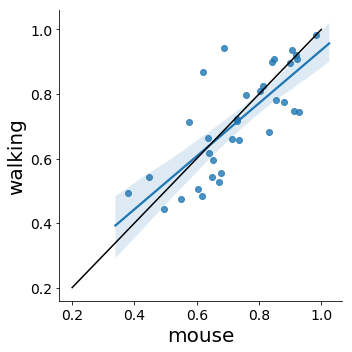

In [110]:
g = sns.lmplot(data=k_values.unstack(), x='mouse', y='walking')
x = np.linspace(0.2, 1)
g.axes[0][0].plot(x, x, color='k')

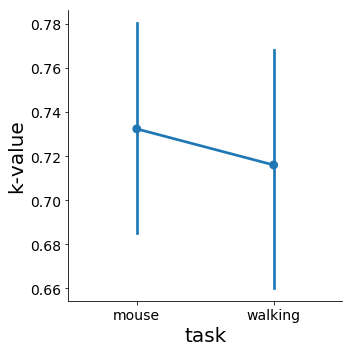

In [111]:
sns.catplot(data=k_values.reset_index(), x='task', y='k-value', kind='point')

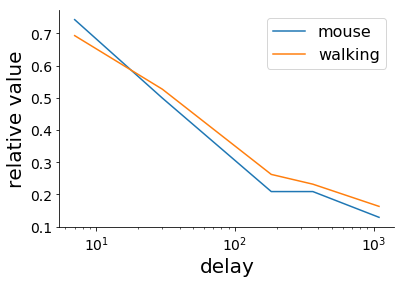

In [113]:
mean_ip = ip.groupby(['task', 'll_delay']).mean().reset_index()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(mean_ip.loc[mean_ip.task=='mouse', 'll_delay'], mean_ip.loc[mean_ip.task=='mouse', 'indiff_point'], label='mouse')
ax.plot(mean_ip.loc[mean_ip.task=='walking', 'll_delay'], mean_ip.loc[mean_ip.task=='walking', 'indiff_point'], label='walking')
ax.set_xlabel('delay')
ax.set_ylabel('relative value')
ax.set_xscale('log')
ax.legend()